# 이 노트의 목표
---
1. ~전체 데이터 셋 길이 분포 확실히 확인. (전부 20s?)~
2. ~train, test 분포확인, 분리~
3. ~audio to mel database 만드는 함수 작성~
4. 데이터 포인트 전체 길이에 맞게 비율대로 레이블링 데이터 생성
    - 일단 다른 전처리 제쳐두고 이 bboxing 로직만 구상
4. (나중에) 각 annotation에 abnormality가 없는 경우 (data imbalancy)


In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
# library import

import librosa
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image


In [6]:
data_root_dir = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/ICBHI_final_database/'


## 여러 df 만들어보기

최종 : df ~ [ wav_filename | duration | train_test ]

### 데이터 파일명 loading

In [8]:
def find_files(directory, format):
    # 지정된 디렉토리 내의 모든 파일과 디렉토리 목록을 가져옵니다.
    all_files = os.listdir(directory)
    if format == 'wav':
        # .wav 확장자를 가진 파일만 필터링합니다.
        files = [file for file in all_files if file.endswith('.wav')]
    elif format == 'txt':
        files = [file for file in all_files if file.endswith('.txt')]

    return files


In [9]:
tmp = find_files(data_root_dir, 'wav')
tmp[0]

'101_1b1_Al_sc_Meditron.wav'

In [10]:
len(tmp)

920

In [11]:
tmp = find_files(data_root_dir, 'txt')
tmp[0]

'211_1p2_Pr_mc_AKGC417L.txt'

In [13]:
len(tmp)

924

In [18]:
# dir내의 파일을 이름으로 같이 묶어서 반환하는 함수 -> [ (wav, txt), ( ... ), ... ]

def find_matching_wav_txt_files(directory):
    # 디렉토리 내의 모든 파일 목록을 가져옵니다.
    all_files = os.listdir(directory)

    # .wav 확장자를 가진 파일들을 찾습니다.
    wav_files = [file for file in all_files if file.endswith('.wav')]

    # .txt 확장자를 가진 파일들을 찾습니다.
    txt_files = [file for file in all_files if file.endswith('.txt')]

    # 파일명(확장자 제외)을 기준으로 .wav와 .txt 파일이 모두 있는 경우를 찾아서 짝지어 줍니다.
    matched_files = []
    for wav_file in wav_files:
        # 확장자를 제외한 파일명을 얻습니다.
        file_name_without_extension = os.path.splitext(wav_file)[0]

        # 해당 파일명을 가진 .txt 파일이 있는지 확인합니다.
        matching_txt_file = file_name_without_extension + '.txt'
        if matching_txt_file in txt_files:
            # .wav와 .txt 파일 경로를 튜플로 묶어 matched_files에 추가합니다.
            #matched_files.append((os.path.join(directory, wav_file), os.path.join(directory, matching_txt_file)))
            matched_files.append((wav_file, matching_txt_file))


    return matched_files


# 폴더 경로를 지정합니다. 이 경로를 실제 파일들이 위치한 폴더 경로로 변경해야 합니다.
directory_path = data_root_dir

# 같은 파일명을 가진 .wav와 .txt 파일들의 경로를 가져옵니다.
matched_file_paths = find_matching_wav_txt_files(directory_path)

# 결과를 출력합니다.
#for wav_path, txt_path in matched_file_paths:
#    print(f'WAV: {wav_path}, TXT: {txt_path}')


type(matched_file_paths)

list

In [20]:
matched_file_paths[0]

('101_1b1_Al_sc_Meditron.wav', '101_1b1_Al_sc_Meditron.txt')

### (1) 데이터 셋 길이 분포 확인


In [23]:
# audio 길이 반환

def get_audio_duration(file_path):
    # 오디오 파일을 로드합니다. y는 오디오 시그널이고, sr은 샘플링 레이트입니다.
    y, sr = librosa.load(file_path)

    # 오디오 파일의 길이(초 단위)를 계산합니다.
    duration = librosa.get_duration(y=y, sr=sr)

    return duration

# 오디오 파일 경로를 지정합니다.
#file_path = 'your_audio_file_path_here.wav'

# 오디오 파일의 길이를 출력합니다.
#print(get_audio_duration(file_path))

In [21]:
wav_path = data_root_dir + matched_file_paths[0][0]
wav_path

'/content/drive/MyDrive/aiffel/AIFFELthon/1_data/ICBHI_final_database/101_1b1_Al_sc_Meditron.wav'

In [24]:
get_audio_duration(wav_path)

20.0

In [45]:
duration = []
for i, _ in matched_file_paths:
    wav_path = data_root_dir + i
    duration.append(get_audio_duration(wav_path))

len(duration)

920

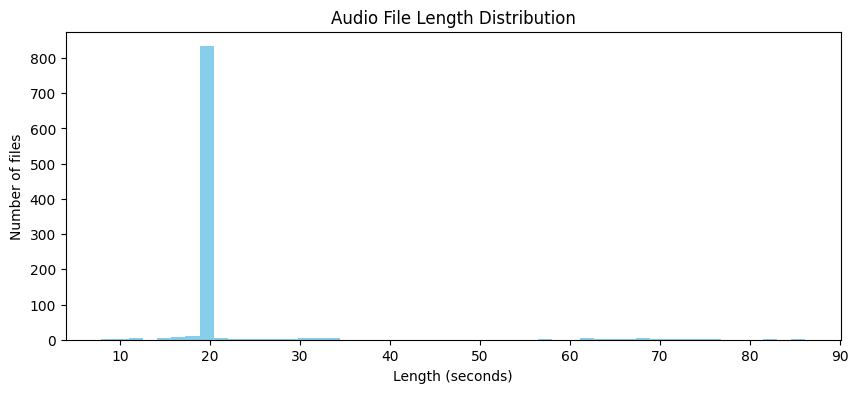

In [46]:
# 길이 분포 plot
def plot_durations(durations):
    plt.figure(figsize=(10, 4))
    plt.hist(durations, bins=50, color='skyblue')
    plt.title('Audio File Length Distribution')
    plt.xlabel('Length (seconds)')
    plt.ylabel('Number of files')
    plt.show()

plot_durations(duration)

In [47]:
# 20초 빼고 plot

no20duration = []
for i in duration:
    if i != 20:
        no20duration.append(i)

len(no20duration)

119

In [48]:
no20duration

[15.856009070294785,
 25.584036281179138,
 18.48,
 15.024036281179137,
 22.96,
 23.728027210884353,
 20.336009070294786,
 19.95201814058957,
 16.944036281179137,
 17.456009070294783,
 17.648027210884354,
 30.0,
 71.45002267573696,
 32.3,
 32.4,
 32.4,
 75.25002267573696,
 20.000045351473922,
 20.000045351473922,
 67.85002267573697,
 33.6,
 29.36,
 30.0,
 30.0,
 14.576009070294784,
 15.728027210884354,
 20.848027210884354,
 14.576009070294784,
 19.63201814058957,
 21.936009070294784,
 20.000045351473922,
 20.000045351473922,
 15.472018140589569,
 18.352018140589568,
 12.528027210884353,
 20.08,
 12.464036281179139,
 12.464036281179139,
 66.75002267573696,
 66.75002267573696,
 86.2,
 67.4,
 67.4,
 12.528027210884353,
 11.248027210884354,
 18.22403628117914,
 17.264036281179138,
 9.584036281179138,
 7.8560090702947845,
 19.97002267573696,
 19.63201814058957,
 16.944036281179137,
 20.848027210884354,
 14.576009070294784,
 14.576009070294784,
 16.24,
 19.98,
 65.05002267573695,
 65.05002267

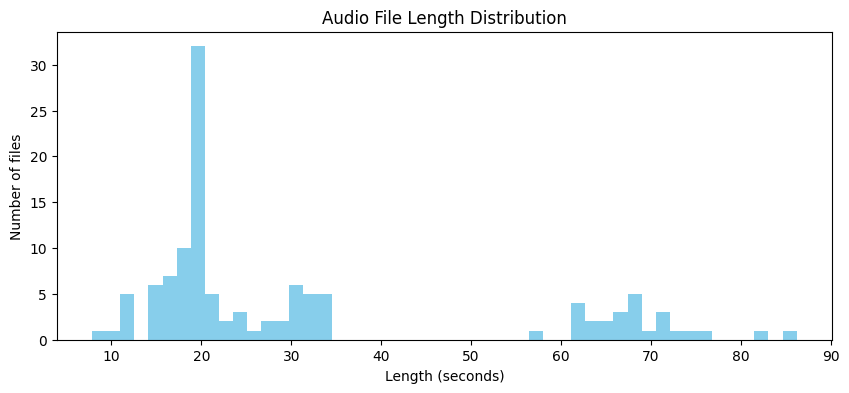

In [49]:
plot_durations(no20duration)

### 하나의 point annotation이 포함된 df 작성

In [37]:
txt_path = data_root_dir + matched_file_paths[0][1]
txt_path

'/content/drive/MyDrive/aiffel/AIFFELthon/1_data/ICBHI_final_database/101_1b1_Al_sc_Meditron.txt'

In [39]:
# 하나의 txt 파일의 정보를 dataframe으로
tmp_df = pd.read_csv(txt_path,
               sep='\t',
               names = ['start', 'end', 'crackles', 'weezels'])
tmp_df.head()

,start,end,crackles,weezels
0,0.036,0.579,0,0
1,0.579,2.450,0,0
2,2.450,3.893,0,0
3,3.893,5.793,0,0
4,5.793,7.521,0,0


### filename - duration df 작성

여기서 바로 좌표구하는거 시작해야겠는데?

하나의 오디오 파일에 해당하는 ...

길이정보 포함된 데이터 프레임 만들어보자

|audio file name|duration|
|---|---|
|.wav|20 ...|

In [67]:
# wav filename list

wav_filename_ls = []
for i, _ in matched_file_paths:
    wav_filename_ls.append(i)

print(wav_filename_ls[0])
len(wav_filename_ls)

101_1b1_Al_sc_Meditron.wav


920

In [70]:
# df: filename - duration

wav_dur_df = pd.DataFrame({
    'WAV Filename': wav_filename_ls,
    'Duration': duration
})

print(wav_dur_df.shape)
wav_dur_df.head()

(920, 2)


,WAV Filename,Duration
0,101_1b1_Al_sc_Meditron.wav,20.000000
1,101_1b1_Pr_sc_Meditron.wav,20.000000
2,102_1b1_Ar_sc_Meditron.wav,20.000000
3,103_2b2_Ar_mc_LittC2SE.wav,20.000000
4,104_1b1_Al_sc_Litt3200.wav,15.856009


### (2) train-test 분포 체크


In [71]:
train_test_dir = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/ICBHI_challenge_train_test.txt'


In [83]:
# ICBHI_challenge_train_test.txt 파일을 읽어서 DataFrame에 추가할 정보를 추출
train_test_ls = []
with open(train_test_dir, 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        filename = parts[0] + '.wav'  # WAV 파일 이름으로 변환
        train_test = parts[1]  # train 또는 test 값
        train_test_ls.append({'WAV Filename': filename, 'train_test': train_test})

# 추출한 정보를 DataFrame으로 변환
train_test_df = pd.DataFrame(train_test_ls)

train_test_df.head()
train_test_df.shape

# 원래 DataFrame과 새로운 DataFrame을 'WAV Filename'을 기준으로 병합
merged_df = pd.merge(wav_dur_df, train_test_df, on='WAV Filename', how='left')

print(merged_df.shape)
merged_df.head()
#print(merged_df)

(920, 3)


,WAV Filename,Duration,train_test
0,101_1b1_Al_sc_Meditron.wav,20.000000,test
1,101_1b1_Pr_sc_Meditron.wav,20.000000,test
2,102_1b1_Ar_sc_Meditron.wav,20.000000,test
3,103_2b2_Ar_mc_LittC2SE.wav,20.000000,train
4,104_1b1_Al_sc_Litt3200.wav,15.856009,test


In [88]:
# train, test 나눠줌

# 'train_test'이 'train'인 행들만 선택하여 새로운 DataFrame 생성
train_df = merged_df[merged_df['train_test'] == 'train']

# 'train_test'이 'test'인 행들만 선택하여 새로운 DataFrame 생성
test_df = merged_df[merged_df['train_test'] == 'test']

print("Train DataFrame:", train_df.shape)
print(train_df.head())
print("\nTest DataFrame:", test_df.shape)
print(test_df.head())

Train DataFrame: (538, 3)
                  WAV Filename  Duration train_test
3   103_2b2_Ar_mc_LittC2SE.wav      20.0      train
10  105_1b1_Tc_sc_Meditron.wav      20.0      train
11  106_2b1_Pl_mc_LittC2SE.wav      20.0      train
12  106_2b1_Pr_mc_LittC2SE.wav      20.0      train
13  107_2b3_Al_mc_AKGC417L.wav      20.0      train

Test DataFrame: (381, 3)
                 WAV Filename   Duration train_test
0  101_1b1_Al_sc_Meditron.wav  20.000000       test
1  101_1b1_Pr_sc_Meditron.wav  20.000000       test
2  102_1b1_Ar_sc_Meditron.wav  20.000000       test
4  104_1b1_Al_sc_Litt3200.wav  15.856009       test
5  104_1b1_Ar_sc_Litt3200.wav  25.584036       test


In [89]:
# test


# 어노테이션 파일 리스트
annotation_files = [
    data_root_dir + '106_2b1_Pl_mc_LittC2SE.txt',
    data_root_dir + '110_1p1_Al_sc_Meditron.txt'
]

# 레이블 데이터를 저장할 리스트
labels = []

# 어노테이션 파일을 순회하며 정보 읽기
for file_path in annotation_files:
    with open(file_path, 'r') as file:
        for line in file:
            start_time, end_time, class1, class2 = line.strip().split('\t')
            # 파일명에서 오디오 ID 추출
            audio_id = os.path.splitext(os.path.basename(file_path))[0]
            # 레이블 데이터에 추가
            labels.append([audio_id, start_time, end_time, class1, class2])

# 레이블 데이터셋 생성
labels_df = pd.DataFrame(labels, columns=['Audio ID', 'Start Time', 'End Time', 'Class 1', 'Class 2'])

# 데이터셋 확인
print(labels_df)

# 데이터셋 CSV 파일로 저장 (옵션)
#labels_df.to_csv('/mnt/data/audio_labels_dataset.csv', index=False)


                  Audio ID Start Time End Time Class 1 Class 2
0   106_2b1_Pl_mc_LittC2SE      0.036    2.164       1       0
1   106_2b1_Pl_mc_LittC2SE      2.164    4.621       1       0
2   106_2b1_Pl_mc_LittC2SE      4.621    7.179       0       0
3   106_2b1_Pl_mc_LittC2SE      7.179    9.636       1       0
4   106_2b1_Pl_mc_LittC2SE      9.636   12.007       1       0
5   106_2b1_Pl_mc_LittC2SE     12.007   14.407       1       0
6   106_2b1_Pl_mc_LittC2SE     14.407   16.793       1       0
7   106_2b1_Pl_mc_LittC2SE     16.793   19.207       1       0
8   106_2b1_Pl_mc_LittC2SE     19.207   19.964       1       0
9   110_1p1_Al_sc_Meditron     2.2855   6.2646       1       1
10  110_1p1_Al_sc_Meditron     6.2646    10.44       1       1
11  110_1p1_Al_sc_Meditron      10.44   14.112       1       1
12  110_1p1_Al_sc_Meditron     14.112   18.217       1       0
13  110_1p1_Al_sc_Meditron     18.217   23.111       0       0
14  110_1p1_Al_sc_Meditron     23.111   26.658       1 

## 224, 224, 3의 mel spec img 데이터셋 저장



In [ ]:
# mel spectogram을 위한 변수 지정
'''
sample_rate = 8000  # 샘플링 레이트 (or 16000)
desired_length = 8  # 원하는 길이 (이 값은 melspectrogram 함수에 직접 사용되지 않음)
n_mels = 64  # 멜 필터뱅크의 수
nfft = 512  # FFT 윈도우 크기
hop_length = nfft // 2  # 프레임 사이의 샘플 수
f_max = 2000  # 최대 주파수

# wav file list, dir
# : wav_filename_ls
len(wav_filename_ls)

# mel 변환 함수
y, sr = librosa.load(audiopath, sr=8000)
S = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_fft=nfft, hop_length=hop_length, n_mels=n_mels, fmax=f_max)
S_dB = librosa.power_to_db(S, ref=np.max)


# 변환된 함수 이미지로 저장
# 새로운 디렉토리에 이미지 파일들 저장
'''
print()

### (3) save audio2mel_jpg 함수 작성

In [136]:
# 함수 작성

def convert_audio_to_melspectrogram(audio_path, save_path, size=(224, 224)):
    '''
    오디오 파일 경로를 받아서 저장 경로에 (224, 224, 3) 크기의 filename_mSpec.jpg 저장
    0. 변수 지정
    1. 파일이름, 디렉토리 정의
    2. audio -> mel
    3. mel -> image(jpg) -> resizing
    4. save image
    '''
    # 0. mel 변수 지정 -> 함수 매개변수로 옮겨도 되는 부분
    sample_rate = 8000  # 샘플링 레이트 (or 16000)
    n_mels = 64  # 멜 필터뱅크의 수
    nfft = 512  # FFT 윈도우 크기
    hop_length = nfft // 2  # 프레임 사이의 샘플 수
    f_max = 2000  # 최대 주파수


    # 1. .wav -> .jpg
    # .wav 파일 경로에서 디렉터리와 파일명(확장자 포함) 분리
    dir_path, filename = os.path.split(audio_path)
    # 파일명에서 확장자를 제거하고, .jpg 확장자를 추가
    base_filename = os.path.splitext(filename)[0]
    jpg_filename = f"{base_filename}_mSpec.jpg"
    # 디렉터리 내에 .jpg 파일 경로 생성
    save_path += jpg_filename


    # 2. to mel
    y, sr = librosa.load(audio_path, sr=sample_rate)
    S = librosa.feature.melspectrogram(y=y,
                                       sr=sr,
                                       n_fft=nfft,
                                       hop_length=hop_length,
                                       n_mels=n_mels,
                                       fmax=f_max)
    S_dB = librosa.power_to_db(S, ref=np.max)


    # 3. to img
    plt.figure(figsize=(2.24, 2.24))  # 이미지 크기를 인치 단위로 설정 (224x224 픽셀이 되도록 DPI 조정 필요)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')

    # 이미지로 저장하기 전에 buffer에 저장
    plt.savefig(save_path, dpi=100)  # DPI를 조정하여 대략적인 픽셀 크기 맞춤
    #plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=100) # DPI를 조정하여 대략적인 픽셀 크기 맞춤
    plt.close()
    # 이미지를 다시 열어서 224x224x3으로 조정
    img = Image.open(save_path).convert('RGB')
    img = img.resize(size, Image.LANCZOS)


    # 4. save img
    if os.path.exists(save_path):
        pass
    else:
        img.save(save_path)

print('ㅎ')

ㅎ


### 저장한 image point 확인

In [137]:
# 사용
save_path = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/224mel_database240311/'

for audio_file_name in wav_filename_ls:
    audio_path = data_root_dir + audio_file_name

    convert_audio_to_melspectrogram(audio_path, save_path, size=(224,224)) # 사용할때 주석 제거
    break

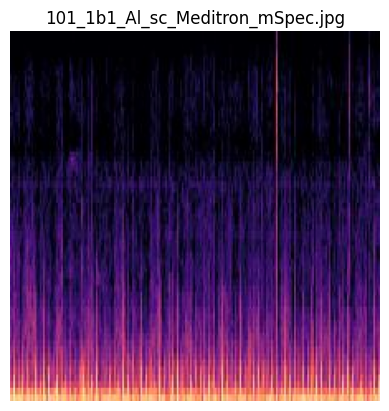

In [138]:
# sample file 확인
image_file = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/224mel_database240311/101_1b1_Al_sc_Meditron_mSpec.jpg'

tmp_img = Image.open(image_file)
plt.figure()
plt.imshow(tmp_img)
plt.title(os.path.basename(image_file))
plt.axis('off')  # 축 표시 안 함
plt.show()

In [139]:
type(tmp_img)

PIL.JpegImagePlugin.JpegImageFile

array([[[  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4],
        ...,
        [  0,   0,   5],
        [  2,   1,   6],
        [  0,   0,   4]],

       [[  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4],
        ...,
        [  0,   0,   4],
        [  2,   1,   6],
        [  0,   0,   4]],

       [[  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4],
        ...,
        [  0,   0,   4],
        [  2,   1,   6],
        [  0,   0,   2]],

       ...,

       [[255, 196, 144],
        [236, 181, 125],
        [255, 231, 169],
        ...,
        [255, 204, 139],
        [238, 175, 121],
        [255, 209, 158]],

       [[254, 201, 149],
        [236, 189, 133],
        [255, 232, 170],
        ...,
        [255, 208, 148],
        [239, 183, 134],
        [255, 212, 169]],

       [[249, 199, 146],
        [235, 190, 133],
        [255, 229, 168],
        ...,
        [249, 198, 141],
        [237, 183, 137],
        [255, 210, 171]]], dtype=uint8)
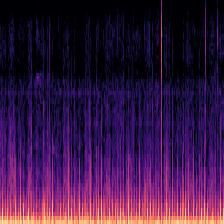

In [140]:
tmp = np.array(tmp_img)
tmp

## (4) 레이블링 데이터셋 고민 (XML)

- annotation 정보를 비율(0, 1)로 전달할 방법 고민
- XML 자료구조 공부


In [ ]:
from xml.etree.ElementTree import Element, SubElement, tostring, ElementTree
import xml.dom.minidom

In [ ]:
# GPT

def create_xml(annotation_info, file_name):
    '''
    annotation_info:
    file_name:

    '''

    root = Element('annotations')

    for annotation in annotation_info:
        obj = SubElement(root, 'object')

        start_time = SubElement(obj, 'start_time')
        start_time.text = str(annotation[0])

        end_time = SubElement(obj, 'end_time')
        end_time.text = str(annotation[1])

        class1 = SubElement(obj, 'class1')
        class1.text = str(annotation[2])

        class2 = SubElement(obj, 'class2')
        class2.text = str(annotation[3])

    # XML 문자열로 변환
    xml_str = xml.dom.minidom.parseString(tostring(root)).toprettyxml(indent="   ")

    # XML 파일로 저장
    with open(f"{file_name}.xml", "w") as f:
        f.write(xml_str)

# 예시 데이터
annotations = [
    [0.107, 2.55, 0, 1],
    [2.55, 6.964, 1, 1],
    [6.964, 11.593, 1, 1],
    [11.593, 16.693, 1, 1],
    [16.693, 19.979, 1, 1]
]

# XML 파일 생성
create_xml(annotations, '221_2b3_Ar_mc_LittC2SE')


In [ ]:
# 임시 함수 작성
'''
txt를 받아서

y = [ p_c, b_x, b_y, b_h, b_w, c_1, c_2 ]

p_c : 1 or 0
b_x, b_y : bbox 좌상단 좌표
b_h : 높이
b_w : 폭
c_1 : crackle. 0 or 1
c_2 : wheeze. 0 or 1


'''

def annot2xml(args):

    pass